Simple Mobile Edge Caching problem

Ep:  20 | Ep_r:  62.31
Ep:  21 | Ep_r:  52.77
Ep:  22 | Ep_r:  59.01
Ep:  23 | Ep_r:  53.05
Ep:  24 | Ep_r:  67.01
Ep:  25 | Ep_r:  54.25
Ep:  26 | Ep_r:  56.22
Ep:  27 | Ep_r:  51.93
Ep:  28 | Ep_r:  59.06
Ep:  29 | Ep_r:  48.02
Ep:  30 | Ep_r:  54.17
Ep:  31 | Ep_r:  60.69
Ep:  32 | Ep_r:  49.42
Ep:  33 | Ep_r:  66.45
Ep:  34 | Ep_r:  45.96
Ep:  35 | Ep_r:  55.79
Ep:  36 | Ep_r:  55.77
Ep:  37 | Ep_r:  51.69
Ep:  38 | Ep_r:  57.44
Ep:  39 | Ep_r:  69.32
Ep:  40 | Ep_r:  58.82
Ep:  41 | Ep_r:  55.54
Ep:  42 | Ep_r:  54.4
Ep:  43 | Ep_r:  60.99
Ep:  44 | Ep_r:  51.11
Ep:  45 | Ep_r:  48.71
Ep:  46 | Ep_r:  57.76
Ep:  47 | Ep_r:  63.54
Ep:  48 | Ep_r:  62.46
Ep:  49 | Ep_r:  47.05
Ep:  50 | Ep_r:  50.65
Ep:  51 | Ep_r:  59.37
Ep:  52 | Ep_r:  53.01
Ep:  53 | Ep_r:  65.92
Ep:  54 | Ep_r:  60.41
Ep:  55 | Ep_r:  57.26
Ep:  56 | Ep_r:  55.06
Ep:  57 | Ep_r:  59.67
Ep:  58 | Ep_r:  47.05
Ep:  59 | Ep_r:  63.75
Ep:  60 | Ep_r:  44.73
Ep:  61 | Ep_r:  63.05

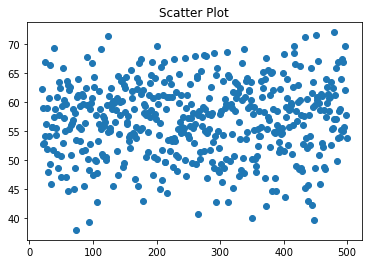

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import gym_hy
from pdb import set_trace as debug
import matplotlib.pyplot as plt

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.99              # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 1000
env = gym.make('dpath-v0')
env = env.unwrapped
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape


class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value


class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

dqn = DQN()

print('\nCollecting experience...')
X = list(range(20,500))
Y = []
for i_episode in range(500):
    s = env.reset()
    ep_r = 0
    while True:
        
        #env.render()
        a = dqn.choose_action(s)

        # take action
        s_, r, done = env.step(a, EPSILON)
        # print(EPSILON)
        EPSILON *= 0.99

        dqn.store_transition(s, a, r, s_)

        ep_r += r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print('Ep: ', i_episode,'| Ep_r: ', round(ep_r/50, 2))
                Y.append(round(ep_r/50, 2))
        if done:
            break
        s = s_
plt.title("Scatter Plot")
plt.scatter(X, Y)
plt.show()        

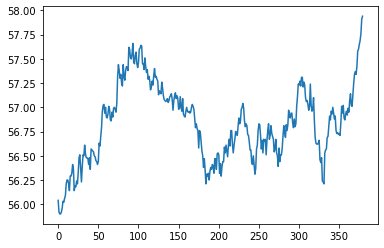

In [7]:
Y_avg = []
for reward_idx in range(len(Y)-100):
    Y_avg.append(round(sum(Y[reward_idx:reward_idx+100])/100,2))
plt.plot(Y_avg)